In [1]:
!date
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

Sun 16 Apr 2017 16:44:39 BST


In [2]:
import pymc3 as pm, theano.tensor as tt

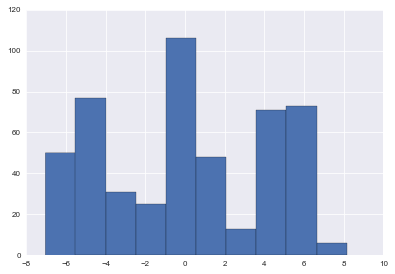

In [3]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [4]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [6]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

/Users/cameron2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|██████████| 10000/10000 [00:49<00:00, 200.95it/s]


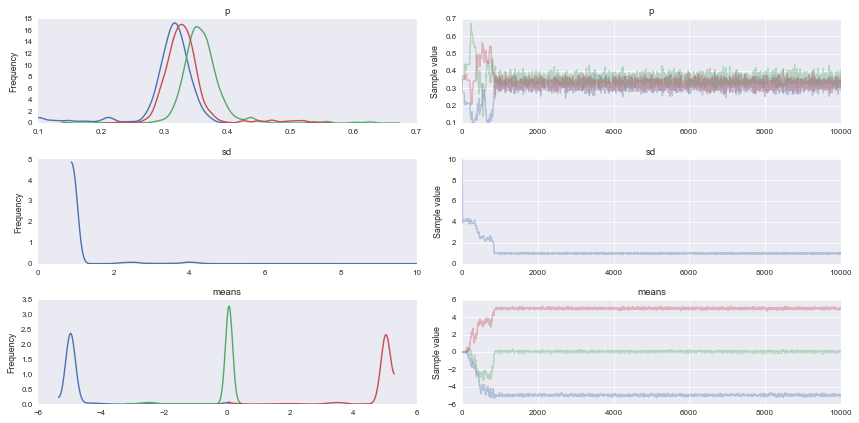

In [7]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

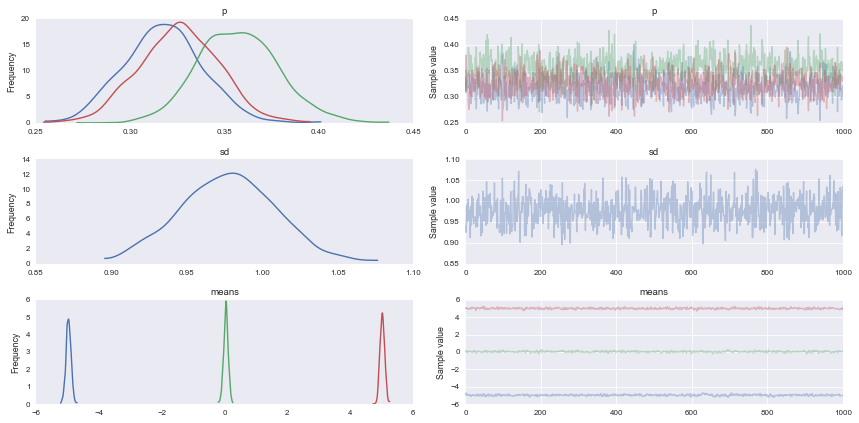

In [8]:
# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

Another example

In [13]:
from __future__ import division

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as tt

In [15]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [16]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

In [18]:
N = 20
K = 30

alpha = 2.
P0 = sp.stats.norm

In [19]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 200)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

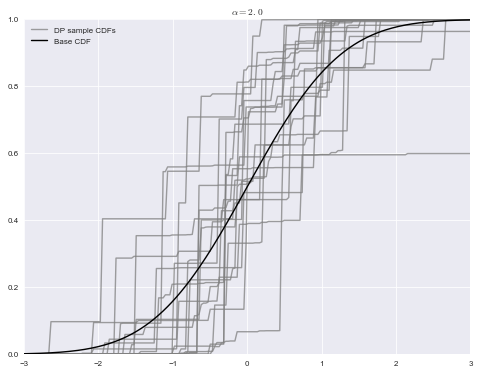

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);

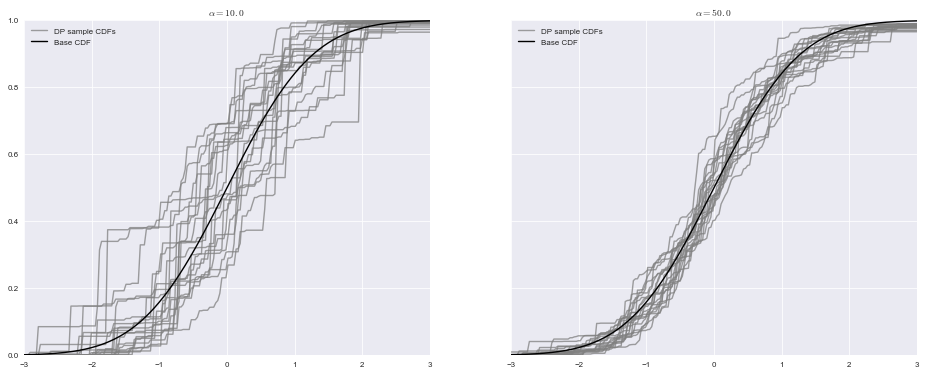

In [21]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2);

K = 200
alpha = 50.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2);

In [24]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import pandas as pd
import theano.tensor as tt
%matplotlib inline

# Clip at 15 components
K = 15

# Create mixture population
centroids = [0, 10, 50]
weights = [(2/5),(2/5),(1/5)]

mix_3 = np.concatenate([np.random.normal(loc=centroids[0], size=int(150*weights[0])), # 60 samples
                        np.random.normal(loc=centroids[1], size=int(150*weights[1])), # 60 samples
                        np.random.normal(loc=centroids[2], size=int(150*weights[2]))])# 30 samples
n = mix_3.size

In [26]:
# Create and fit model
with pm.Model() as Mod_dir:
    alpha = pm.Gamma('alpha', 1., 1.)

    beta = pm.Beta('beta', 1., alpha, shape=K)

    w = pm.Deterministic('w', beta * tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]]))

    component = pm.Categorical('component', w, shape=n)

    tau = pm.Gamma("tau", 1.0, 1.0, shape=K)

    mu = pm.Normal('mu', 0, tau=tau, shape=K)

    obs = pm.Normal('obs',
                    mu[component], 
                    tau=tau[component],
                    observed=mix_3)

    step1 = pm.Metropolis(vars=[alpha, beta, w, tau, mu, obs])
    step2 = pm.CategoricalGibbsMetropolis(vars=[component])
#     step2 = pm.ElemwiseCategorical([component], np.arange(K)) # Much, much faster than the above

    tr = pm.sample(1e4, [step1, step2], njobs=multiprocessing.cpu_count())

#burn-in = 1000, thin by grabbing every 5th idx
pm.traceplot(tr[1e3::5])

PicklingError: Can't pickle <type 'instancemethod'>: it's not found as __builtin__.instancemethod